Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Transforms

In this tutorial, we demonstrate how to use TorchGeo's data augmentation transforms and provide examples of how to utilize them in your experiments with multispectral imagery.

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

Install TorchGeo

In [1]:
%pip install torchgeo

## Imports

In [2]:
import os
import tempfile
from typing import Dict, Optional

import kornia.augmentation as K
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT100
from torchgeo.transforms import AugmentationSequential, indices

## Custom Transforms

Here we create a transform to show an example of how you can chain custom operations along with TorchGeo and Kornia transforms/augmentations. Note how our transform takes as input a Dict of Tensors. We specify our data by the keys ["image", "mask", "label", etc.] and follow this standard across TorchGeo datasets.

In [3]:
class MinMaxNormalize(K.IntensityAugmentationBase2D):
    """Normalize channels to the range [0, 1] using min/max values."""

    def __init__(self, mins: Tensor, maxs: Tensor) -> None:
        super().__init__(p=1)
        self.flags = {"mins": mins.view(1, -1, 1, 1), "maxs": maxs.view(1, -1, 1, 1)}

    def apply_transform(
        self,
        input: Tensor,
        params: Dict[str, Tensor],
        flags: Dict[str, int],
        transform: Optional[Tensor] = None,
    ) -> Tensor:
        return (input - flags["mins"]) / (flags["maxs"] - flags["mins"] + 1e-10)

## Dataset Bands and Statistics

Below we have min/max values calculated across the dataset per band. The values were clipped to the interval [0, 98] to stretch the band values and avoid outliers influencing the band histograms.

In [4]:
mins = torch.tensor(
    [
        1013.0,
        676.0,
        448.0,
        247.0,
        269.0,
        253.0,
        243.0,
        189.0,
        61.0,
        4.0,
        33.0,
        11.0,
        186.0,
    ]
)
maxs = torch.tensor(
    [
        2309.0,
        4543.05,
        4720.2,
        5293.05,
        3902.05,
        4473.0,
        5447.0,
        5948.05,
        1829.0,
        23.0,
        4894.05,
        4076.05,
        5846.0,
    ]
)
bands = {
    "B1": "Coastal Aerosol",
    "B2": "Blue",
    "B3": "Green",
    "B4": "Red",
    "B5": "Vegetation Red Edge 1",
    "B6": "Vegetation Red Edge 2",
    "B7": "Vegetation Red Edge 3",
    "B8": "NIR 1",
    "B8A": "NIR 2",
    "B9": "Water Vapour",
    "B10": "SWIR 1",
    "B11": "SWIR 2",
    "B12": "SWIR 3",
}

The following variables can be used to control the dataloader.

In [5]:
batch_size = 4
num_workers = 2

## Load the EuroSat MS dataset and dataloader

We will use the [EuroSAT](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#eurosat) dataset throughout this tutorial. Specifically, a subset containing only 100 images.

In [6]:
root = os.path.join(tempfile.gettempdir(), "eurosat100")
dataset = EuroSAT100(root, download=True)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
dataloader = iter(dataloader)
print(f"Number of images in dataset: {len(dataset)}")
print(f"Dataset Classes: {dataset.classes}")

  0%|          | 0/7717354 [00:00<?, ?it/s]

  0%|          | 0/1152 [00:00<?, ?it/s]

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

Number of images in dataset: 60
Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Load a sample and batch of images and labels

Here we test our dataset by loading a single image and label. Note how the image is of shape (13, 64, 64) containing a 64x64 shape with 13 multispectral bands.

In [7]:
sample = dataset[0]
x, y = sample["image"], sample["label"]
print(x.shape, x.dtype, x.min(), x.max())
print(y, dataset.classes[y])

torch.Size([13, 64, 64]) torch.float32 tensor(12.) tensor(5594.)
tensor(0) AnnualCrop


Here we test our dataloader by loading a single batch of images and labels. Note how the image is of shape (4, 13, 64, 64) containing 4 samples due to our batch_size.

In [8]:
batch = next(dataloader)
x, y = batch["image"], batch["label"]
print(x.shape, x.dtype, x.min(), x.max())
print(y, [dataset.classes[i] for i in y])

torch.Size([4, 13, 64, 64]) torch.float32 tensor(4.) tensor(5252.)
tensor([2, 7, 7, 9]) ['HerbaceousVegetation', 'Residential', 'Residential', 'SeaLake']


## Transforms Usage

Transforms are able to operate across batches of samples and singular samples. This allows them to be used inside the dataset itself or externally, chained together with other transform operations using `nn.Sequential`. 

In [9]:
transform = MinMaxNormalize(mins, maxs)
print(x.shape)
x = transform(x)
print(x.dtype, x.min(), x.max())

torch.Size([4, 13, 64, 64])
torch.float32 tensor(-0.0057) tensor(0.8807)


Indices can also be computed on batches of images and appended as an additional band to the specified channel dimension. Notice how the number of channels increases from 13 -> 14.

In [10]:
transform = indices.AppendNDVI(index_nir=7, index_red=3)
batch = next(dataloader)
x = batch["image"]
print(x.shape)
x = transform(x)
print(x.shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 14, 64, 64])


This makes it incredibly easy to add indices as additional features during training by chaining multiple Appends together.

In [11]:
transforms = nn.Sequential(
    MinMaxNormalize(mins, maxs),
    indices.AppendNDBI(index_swir=11, index_nir=7),
    indices.AppendNDSI(index_green=3, index_swir=11),
    indices.AppendNDVI(index_nir=7, index_red=3),
    indices.AppendNDWI(index_green=2, index_nir=7),
)

batch = next(dataloader)
x = batch["image"]
print(x.shape)
x = transforms(x)
print(x.shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 17, 64, 64])


It's even possible to chain indices along with augmentations from kornia for a single callable during training.

In [12]:
transforms = AugmentationSequential(
    MinMaxNormalize(mins, maxs),
    indices.AppendNDBI(index_swir=11, index_nir=7),
    indices.AppendNDSI(index_green=3, index_swir=11),
    indices.AppendNDVI(index_nir=7, index_red=3),
    indices.AppendNDWI(index_green=2, index_nir=7),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    data_keys=["image"],
)

batch = next(dataloader)
print(batch["image"].shape)
batch = transforms(batch)
print(batch["image"].shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 17, 64, 64])


All of our transforms are `nn.Modules`. This allows us to push them and the data to the GPU to see significant gains for large scale operations.

In [13]:
!nvidia-smi

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+---------------------------------------

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transforms = AugmentationSequential(
    MinMaxNormalize(mins, maxs),
    indices.AppendNDBI(index_swir=11, index_nir=7),
    indices.AppendNDSI(index_green=3, index_swir=11),
    indices.AppendNDVI(index_nir=7, index_red=3),
    indices.AppendNDWI(index_green=2, index_nir=7),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.RandomAffine(degrees=(0, 90), p=0.25),
    K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0), p=0.25),
    K.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), p=0.25),
    data_keys=["image"],
)

transforms_gpu = AugmentationSequential(
    MinMaxNormalize(mins.to(device), maxs.to(device)),
    indices.AppendNDBI(index_swir=11, index_nir=7),
    indices.AppendNDSI(index_green=3, index_swir=11),
    indices.AppendNDVI(index_nir=7, index_red=3),
    indices.AppendNDWI(index_green=2, index_nir=7),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.RandomAffine(degrees=(0, 90), p=0.25),
    K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0), p=0.25),
    K.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), p=0.25),
    data_keys=["image"],
).to(device)


def get_batch_cpu():
    return dict(image=torch.randn(64, 13, 512, 512).to("cpu"))


def get_batch_gpu():
    return dict(image=torch.randn(64, 13, 512, 512).to(device))

In [15]:
%%timeit -n 1 -r 5
_ = transforms(get_batch_cpu())

14.3 s ± 746 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [16]:
%%timeit -n 1 -r 5
_ = transforms_gpu(get_batch_gpu())

3.18 s ± 1.62 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


## Visualize Images and Labels

This is a Google Colab browser for the EuroSAT dataset. Adjust the slider to visualize images in the dataset.

In [60]:
transforms = AugmentationSequential(MinMaxNormalize(mins, maxs), data_keys=["image"])
dataset = EuroSAT100(root, transforms=transforms)

Class Label: Highway


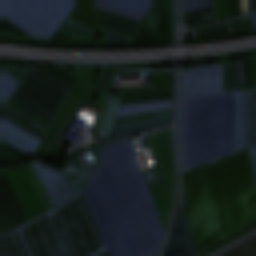

In [98]:
# @title EuroSat Multispectral (MS) Browser  { run: "auto", vertical-output: true }
idx = 21  # @param {type:"slider", min:0, max:59, step:1}
sample = dataset[idx]
rgb = sample["image"][0, 1:4]
image = T.ToPILImage()(rgb)
print(f"Class Label: {dataset.classes[sample['label']]}")
image.resize((256, 256), resample=Image.BILINEAR)